In [2]:
import datetime
import os
from pathlib import Path

import laspy
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import torch
import geopandas as gpd
import py4dgeo
import py4dgeo.epoch
import pandas as pd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import pipeline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Debuging Parameters

In [3]:
log_dir = f"outputs/{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
nth = 1

os.makedirs(log_dir, exist_ok=True)
print(f"Logging to {log_dir}")
print(f"Plotting every {nth}th point")

Logging to outputs/20250312-2308
Plotting every 1th point


### Parameters

In [4]:
input_file = "/home/sam/Documents/datasets/WHU/3-Mountain/combined.las"
las = laspy.read(input_file)
x = las.x
y = las.y
z = las.z

shp_file = "/home/sam/Documents/datasets/WHU/3-Mountain/combined_stable.shp"
satble_shp = gpd.read_file(shp_file)

In [5]:
center_x = np.mean(x) + 15 # Center x of deformation
center_y = np.mean(y) + 15 # Center y of deformation
radius = 15                # Radius of the mining region
max_depth = 9             # Maximum depth at the center
sigma = radius / 2.0       # Spread of the deformation
noise_std = 0.1            # Noise standard deviation in meters

angle_x_deg = 0.4    # Rotation around x-axis in degrees
angle_y_deg = 0.1    # Rotation around y-axis in degrees
angle_z_deg = 17.5   # Rotation around z-axis in degrees
translation_x = 10.0 # Translation along x-axis in meters
translation_y = -5.0 # Translation along y-axis in meters
translation_z = 0.2  # Translation along z-axis in meters

DEVICE = torch.device("cuda:{}".format(0))
PADDING = "same"
VOXEL_SIZE = 2.0
PV = 5
NV = -1
PPV = -1
NUM_WORKERS = 24
ROTATION_CHOICE = "gen"
# ROTATION_CHOICE = "EULER-S=10-LIMITED-DUPLICATES"

QUANTILE_THR = 0.2
ICP_VERSION = "generalized"
MAX_ITER = 2048

In [6]:
analytical_volume = pipeline.get_analytical_volume(sigma, radius, max_depth)
print("Analytical ground truth volume removed (m^3):", analytical_volume)

# T = pipeline.get_transform_matrix(angle_x_deg, angle_y_deg, angle_z_deg, translation_x, translation_y, translation_z)
T = pipeline.get_random_transformation()
print("Ground truth transformation matrix (4x4):", "\n", np.linalg.inv(T))

Analytical ground truth volume removed (m^3): 2750.379626027184
Ground truth transformation matrix (4x4): 
 [[ 7.34540863e-01  6.77163069e-01 -4.35878338e-02  7.15987853e+00]
 [-6.78001849e-01  7.35031319e-01 -6.51556327e-03 -4.61004389e+00]
 [ 2.76263242e-02  3.43385794e-02  9.99028352e-01 -1.72416109e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Pseudo data generator for the WHU-TLS Mountain scan

In [7]:
z_deformed, mask = pipeline.apply_deformation(x, y, z, center_x, center_y, radius, max_depth, sigma)
x_noisy, y_noisy, z_noisy = pipeline.apply_noise(x, y, z_deformed, noise_std)
x_trans, y_trans, z_trans = pipeline.apply_transformation(x_noisy, y_noisy, z_noisy, T)

In [8]:
new_header = laspy.LasHeader(point_format=las.header.point_format, version=las.header.version)
new_header.scales = las.header.scales
new_header.offsets = las.header.offsets

new_las = laspy.LasData(new_header)
new_las.x = x_trans
new_las.y = y_trans
new_las.z = z_trans

new_las.write(f"{log_dir}/alt.las")

### Registration wit EGS

In [9]:
start_timestamp = datetime.datetime.now()

In [10]:
source = np.vstack((x_trans, y_trans, z_trans)).transpose()
target = np.vstack((x, y, z)).transpose()

In [11]:
EGS_T = pipeline.EGS(
    source=source,
    target=target,
    voxel_size=VOXEL_SIZE,
    padding=PADDING,
    ppv=PPV,
    pv=PV,
    nv=NV,
    num_workers=NUM_WORKERS,
    rotation_choice=ROTATION_CHOICE,
    rotation_root_path="exhaustive-grid-search/data/rotations",
)

FFT Convolution: 100%|██████████| 1656/1656 [06:48<00:00,  4.06it/s]


In [12]:
GICP_T = pipeline.auto_GICP(
    source=source, target=target, T_init=EGS_T, thr=QUANTILE_THR, max_iter=MAX_ITER
)

0.7646597946747752


In [13]:
gt = np.linalg.inv(T)

rre_one = pipeline.compute_rre(np.eye(4,4), gt)
rte_one = pipeline.compute_rte(np.eye(4,4), gt)
print(rre_one)
print(rte_one)

rre = pipeline.compute_rre(EGS_T, gt)
rte = pipeline.compute_rte(EGS_T, gt)
print("Rotation error (degrees):", rre)
print("Translation error (m):", rte)

rre_refined = pipeline.compute_rre(GICP_T, gt)
rte_refined = pipeline.compute_rte(GICP_T, gt)
print("Refined rotation error (degrees):", rre_refined)
print("Refined translation error (m):", rte_refined)

42.75187740804357
8.688446162551676
Rotation error (degrees): 1.2147201722282663
Translation error (m): 2.3200372111790073
Refined rotation error (degrees): 0.005699772914318187
Refined translation error (m): 0.00794424051146128


In [14]:
x_refined, y_refined, z_refined = pipeline.apply_transformation(x_trans, y_trans, z_trans, GICP_T)
refined = np.vstack((x_refined, y_refined, z_refined)).transpose()

### Change Detection

```bash
git submodule update --init --recursive
cd py4dgeo
python -m pip install -v --editable .
```

In [15]:
stable_before, mask_before = pipeline.isolate_stable(target, satble_shp)
stable_after,  mask_after  = pipeline.isolate_stable(refined, satble_shp)

epoch_stabel_before = py4dgeo.Epoch(stable_before)
epoch_stabel_after  = py4dgeo.Epoch(stable_after)

In [16]:
epoch_stabel_after.build_kdtree()
indices, distances = epoch_stabel_after.kdtree.nearest_neighbors(
    epoch_stabel_before.cloud, 1
)
distances = np.sqrt(distances)

print(f"C2C Median distances: {np.median(distances):.3f} m")
print(f"C2C Std. dev. of distances: {np.std(distances):.3f} m")

[2025-03-12 23:21:28][INFO] Building KDTree structure with leaf parameter 10
C2C Median distances: 0.047 m
C2C Std. dev. of distances: 0.023 m


In [17]:
m3c2 = py4dgeo.M3C2(
    epochs=(epoch_stabel_before, epoch_stabel_after),
    corepoints=epoch_stabel_before.cloud[::],
    normal_radii=(0.5,),
    cyl_radius=(0.5),
    max_distance=(5.0),
    registration_error=(0.0),
)
m3c2_distances_stableparts, uncertainties_stableparts = m3c2.run()
reg_target_source = np.nanstd(m3c2_distances_stableparts)

print(f"M3C2 Median distances: {np.nanmedian(m3c2_distances_stableparts):.3f} m")
print(f"M3C2 Std. dev. of distances: {np.nanstd(m3c2_distances_stableparts):.3f} m")
print(f"Registration error {reg_target_source:.3f} m.")

[2025-03-12 23:21:29][INFO] Building KDTree structure with leaf parameter 10
M3C2 Median distances: 0.003 m
M3C2 Std. dev. of distances: 0.012 m
Registration error 0.012 m.


In [18]:
epoch_before = py4dgeo.Epoch(target)
epoch_after = py4dgeo.Epoch(refined)

corepoints_pcd        = o3d.geometry.PointCloud()
corepoints_pcd.points = o3d.utility.Vector3dVector(epoch_before.cloud)
corepoints_pcd        = corepoints_pcd.voxel_down_sample(voxel_size=0.1)
corepoints            = np.asarray(corepoints_pcd.points)

m3c2 = py4dgeo.M3C2(
    epochs=(epoch_before, epoch_after),
    corepoints=corepoints,
    normal_radii=(0.5,),
    cyl_radii=(0.5,),
    max_distance=(15.0),
    registration_error=(reg_target_source),
)
m3c2_distances, uncertainties = m3c2.run()
change_sign = np.where(abs(m3c2_distances) > uncertainties["lodetection"], True, False)

[2025-03-12 23:21:46][WARNING] DEPRECATION: use cyl_radius instead of cyl_radii. In a future version, cyl_radii will be removed!


[2025-03-12 23:21:46][INFO] Building KDTree structure with leaf parameter 10
[2025-03-12 23:22:05][INFO] Building KDTree structure with leaf parameter 10


### Volume Calculation

In [19]:
hulls = pipeline.segment_changes(corepoints, change_sign)

selected_indices    = [np.argmax([hull.area for hull in hulls])]
selected_hulls      = [hulls[i] for i in selected_indices]
inside_mask_refined = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, refined[:, :2])
inside_mask_raw     = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, target[:, :2])

filtered_refined = refined[inside_mask_refined]
filtered_raw     = target[inside_mask_raw]

filtered_refined_x, filtered_refined_y, filtered_refined_z = filtered_refined.T
filtered_raw_x, filtered_raw_y, filtered_raw_z = filtered_raw.T

In [20]:
dem_before, dem_after, dem_grid_x, dem_grid_y = pipeline.reletive_DEM(
    filtered_raw,
    filtered_refined,
    grid_res=0.01,
    method="linear",
    mask_hulls=selected_hulls,
)

net_volume, cut_volume, fill_volume, diff_DEMs = pipeline.calculate_volume(
    dem_before, dem_after, grid_res=0.01, threshold=reg_target_source
)

volume_cut_acc = (analytical_volume + net_volume) / analytical_volume * 100

In [21]:
print("Cut Volume (removed): {} m³".format(cut_volume))
print("Fill Volume (added): {} m³".format(fill_volume))
print("Net Volume Change: {} m³".format(net_volume))
print("Volume Change Accuracy: {}%".format(volume_cut_acc))

Cut Volume (removed): 2754.0203607506364 m³
Fill Volume (added): 12.03242476637991 m³
Net Volume Change: -2741.9879359842566 m³
Volume Change Accuracy: 0.3051102460007906%


In [22]:
finish_timestamp = datetime.datetime.now()
elapsed_time = finish_timestamp - start_timestamp
print("Elapsed time:", elapsed_time)

Elapsed time: 0:16:21.141279


# Log

In [23]:
params = {
    "Center X": center_x,
    "Center Y": center_y,
    "Radius": radius,
    "Max Depth": max_depth,
    "Sigma": sigma,
    "Noise Std Dev": noise_std,
    "Analytical Removed": analytical_volume,
    "Angle X": angle_x_deg,
    "Angle Y": angle_y_deg,
    "Angle Z": angle_z_deg,
    "Translation X": translation_x,
    "Translation Y": translation_y,
    "Translation Z": translation_z,
    "Ground truth": np.linalg.inv(T),
    "Device": DEVICE,
    "Padding": PADDING,
    "Voxel Size": VOXEL_SIZE,
    "PV": PV,
    "NV": NV,
    "PPV": PPV,
    "Num Workers": NUM_WORKERS,
    "Rotation Choice": ROTATION_CHOICE,
    "Quantile Threshold": QUANTILE_THR,
    "ICP Version": ICP_VERSION,
    "Max Iterations": MAX_ITER,
}

with open(Path(log_dir) / "parameters.txt", "w") as log_file:
    for key, value in params.items():
        log_file.write(f"{key}: {value}\n")

with open(Path(log_dir) / "result.txt", "w") as log_file:
    log_file.write("Rotation error (degrees): {}\n".format(rre))
    log_file.write("Translation error (m): {}\n".format(rte))
    log_file.write("Refined rotation error (degrees): {}\n".format(rre_refined))
    log_file.write("Refined translation error (m): {}\n".format(rte_refined))
    log_file.write("estimated_EGS:\n{}\n".format(EGS_T))
    log_file.write("estimated_GICP:\n{}\n".format(GICP_T))
    
    log_file.write("C2C Median distances: {} m\n".format(np.median(distances)))
    log_file.write("C2C Std. dev. of distances: {} m\n".format(np.std(distances)))
    log_file.write("M3C2 Median distances: {} m\n".format(np.nanmedian(m3c2_distances_stableparts)))
    log_file.write("M3C2 Std. dev. of distances: {} m\n".format(np.nanstd(m3c2_distances_stableparts)))
    log_file.write("Registration error (est): {} m\n".format(reg_target_source))
    
    log_file.write("hulls number: {}\n".format(len(hulls)))
    log_file.write("selected hulls: {}\n".format(selected_indices))
    log_file.write("hulls area: {}\n".format([hull.area for hull in hulls]))
    log_file.write("Cut Volume (removed): {} m³\n".format(cut_volume))
    log_file.write("Fill Volume (added): {} m³\n".format(fill_volume))
    log_file.write("Net Volume Change: {} m³\n".format(net_volume))
    log_file.write("Volume Change Accuracy: {}%\n".format(volume_cut_acc))
    
    log_file.write("Elapsed time: {}\n".format(elapsed_time))

# Image

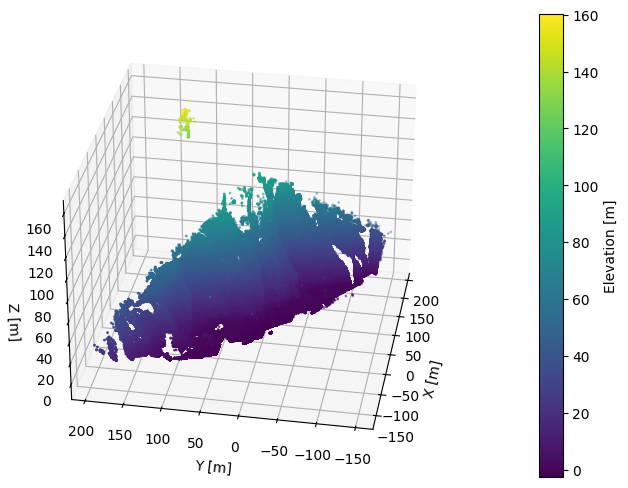

In [24]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))
scatter = ax.scatter(x[::nth], y[::nth], z[::nth], c=z[::nth], cmap='viridis', s=1, marker='o')

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=30.0, azim=190.0)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Elevation [m]")

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_Raw.png", dpi=300, bbox_inches="tight")
plt.show()

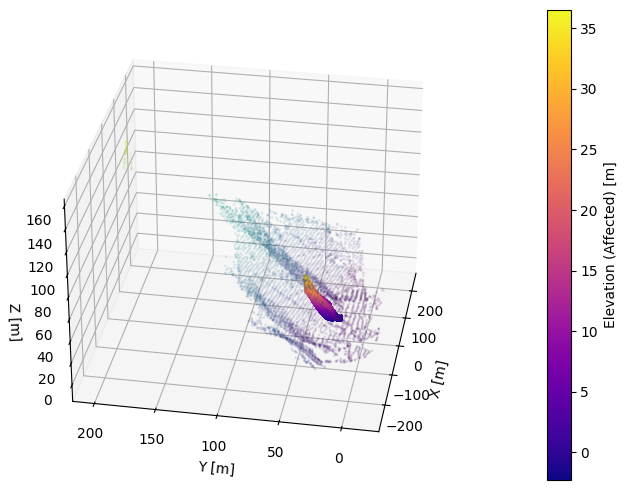

In [36]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

tem_points = np.vstack((x_trans[~mask][::nth], y_trans[~mask][::nth], z_trans[~mask][::nth])).transpose()

unaffected_alter_pcd        = o3d.geometry.PointCloud()
unaffected_alter_pcd.points = o3d.utility.Vector3dVector(tem_points)
unaffected_alter_pcd        = unaffected_alter_pcd.voxel_down_sample(voxel_size=4)
unaffected_alter_ds         = np.asarray(unaffected_alter_pcd.points)

scatter_unaffected = ax.scatter(
    unaffected_alter_ds[:, 0],
    unaffected_alter_ds[:, 1],
    unaffected_alter_ds[:, 2],
    c=unaffected_alter_ds[:, 2],
    cmap="viridis",
    s=1,
    marker="o",
    alpha=0.1,
)
scatter_affected = ax.scatter(
    x_trans[mask][::nth],
    y_trans[mask][::nth],
    z_trans[mask][::nth],
    c=z_trans[mask][::nth],
    cmap="plasma",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=30.0, azim=190.0)

cbar = plt.colorbar(scatter_affected, ax=ax, pad=0.1)
cbar.set_label("Elevation (Affected) [m]")

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_Alt.png", dpi=300, bbox_inches="tight")
plt.show()

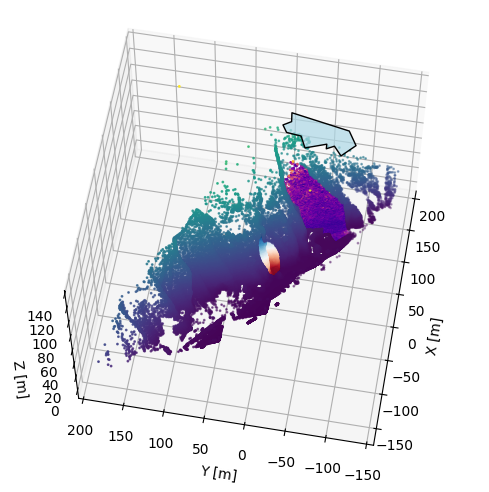

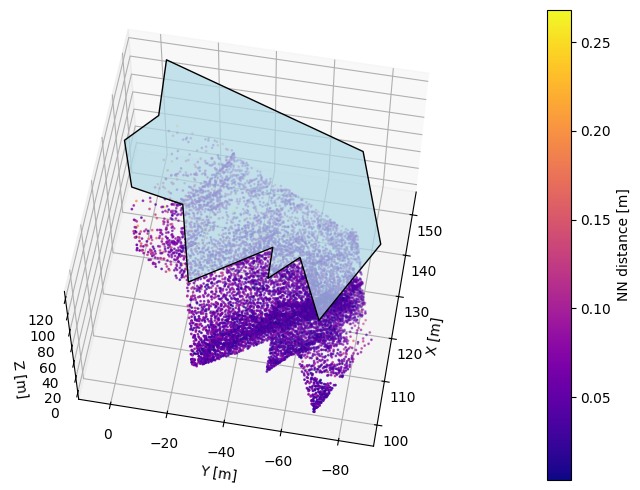

In [26]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

all_x, all_y, all_z = [], [], []
for geom in satble_shp.geometry:
    if geom is None:
        print("Skipping missing geometry")
        continue

    def process_polygon(poly):
        coords = list(poly.exterior.coords)
        if len(coords[0]) == 3:
            xs, ys, zs = zip(*coords)
        else:
            xs, ys = zip(*coords)
            zs = [120] * len(xs)  # Arbitrary height if not present
        all_x.extend(xs)
        all_y.extend(ys)
        all_z.extend(zs)

        verts = [list(zip(xs, ys, zs))]
        poly3d = Poly3DCollection(
            verts, facecolor="lightblue", edgecolor="black", alpha=0.7
        )
        ax.add_collection3d(poly3d)

    if geom.geom_type == "MultiPolygon":
        for poly in geom.geoms:
            process_polygon(poly)
    elif geom.geom_type == "Polygon":
        process_polygon(geom)

combined_mask = (~mask) & mask_after

scatter_unaffe = ax.scatter(
    x_refined[combined_mask][::100],
    y_refined[combined_mask][::100],
    z_refined[combined_mask][::100],
    c=z_refined[combined_mask][::100],
    cmap="viridis",
    s=1,
    marker="o",
)
scatter_affect = ax.scatter(
    x_refined[mask][::100],
    y_refined[mask][::100],
    z_refined[mask][::100],
    c=z_refined[mask][::100],
    cmap="RdBu",
    s=1,
    marker="o",
)
scatter_stable = ax.scatter(
    stable_before[::100, 0],
    stable_before[::100, 1],
    stable_before[::100, 2],
    c=distances[::100],
    cmap="plasma",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=60.0, azim=190.0)

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_stable_rel.png", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

all_x, all_y, all_z = [], [], []
for geom in satble_shp.geometry:
    if geom is None:
        print("Skipping missing geometry")
        continue

    def process_polygon(poly):
        coords = list(poly.exterior.coords)
        if len(coords[0]) == 3:
            xs, ys, zs = zip(*coords)
        else:
            xs, ys = zip(*coords)
            zs = [120] * len(xs) # Arbitrary height if not present
        all_x.extend(xs)
        all_y.extend(ys)
        all_z.extend(zs)

        verts = [list(zip(xs, ys, zs))]
        poly3d = Poly3DCollection(
            verts, facecolor="lightblue", edgecolor="black", alpha=0.7
        )
        ax.add_collection3d(poly3d)

    if geom.geom_type == "MultiPolygon":
        for poly in geom.geoms:
            process_polygon(poly)
    elif geom.geom_type == "Polygon":
        process_polygon(geom)

combined_mask = (~mask) & mask_after

scatter_stable = ax.scatter(
    stable_before[::100, 0],
    stable_before[::100, 1],
    stable_before[::100, 2],
    c=distances[::100],
    cmap="plasma",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=60.0, azim=190.0)

cbar = fig.colorbar(scatter_stable, ax=ax, pad=0.1)
cbar.set_label("NN distance [m]")

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_stable_isolate.png", dpi=300, bbox_inches="tight")
plt.show()

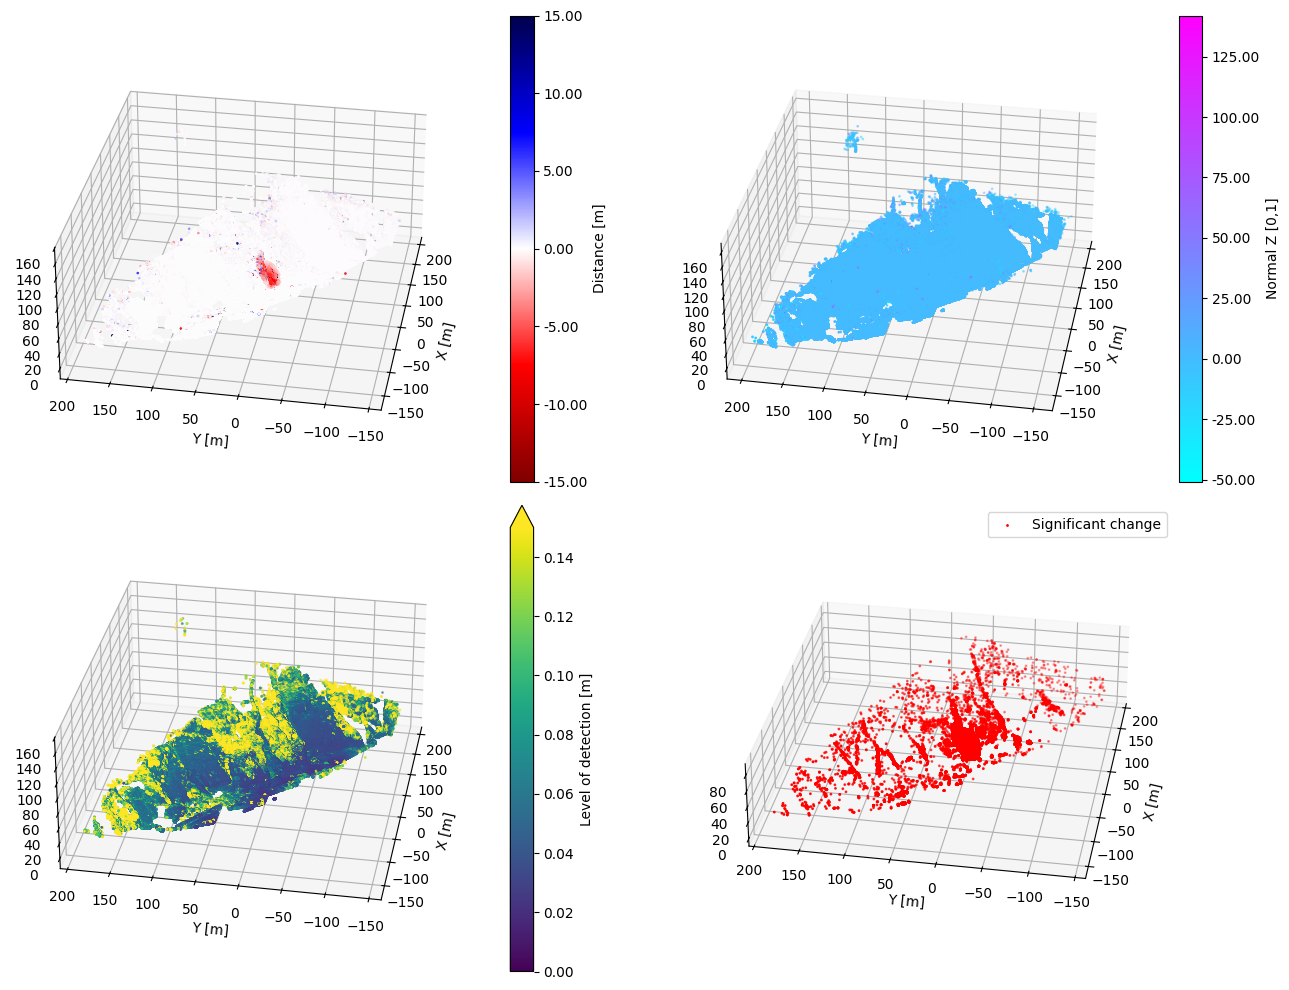

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={"projection": "3d"})
(ax1, ax2), (ax3, ax4) = axs

# Plot the distances
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=m3c2_distances,
    cmap="seismic_r",
    vmin=-15.0,
    vmax=15.0,
    s=1,
    marker='*',
)
plt.colorbar(d, format=("%.2f"), label="Distance [m]", ax=ax1)

# Plot the directions
directions = m3c2.directions()
dz = ax2.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=directions[:, 2],
    cmap="cool",
    s=1,
)
plt.colorbar(dz, format=("%.2f"), label="Normal Z [0,1]", ax=ax2)

# Plot the level of detection values
l = ax3.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=uncertainties["lodetection"],
    cmap="viridis",
    vmin=0.0,
    vmax=0.15,
    s=1,
)
plt.colorbar(
    l,
    format=("%.2f"),
    label="Level of detection [m]",
    ax=ax3,
    extend="max",
)

# Plot the significant change values (boolean)
ax4.scatter(
    corepoints[change_sign][:, 0],
    corepoints[change_sign][:, 1],
    corepoints[change_sign][:, 2],
    label="Significant change",
    c="red",
    s=1,
)
ax4.legend()

# Add plot elements
for ax_set in axs:
    for ax in ax_set:
        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")
        ax.set_aspect("equal")
        ax.view_init(elev=30.0, azim=190.0)

plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet.png", dpi=300, bbox_inches="tight")
plt.show()

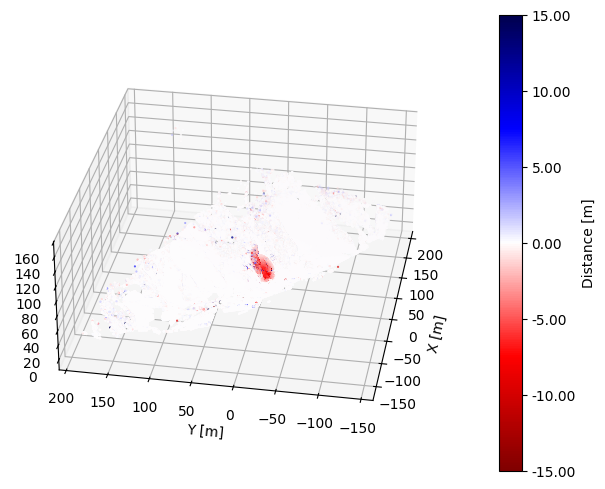

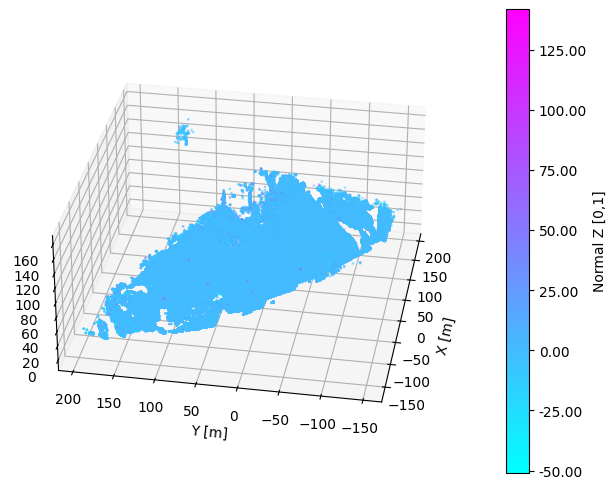

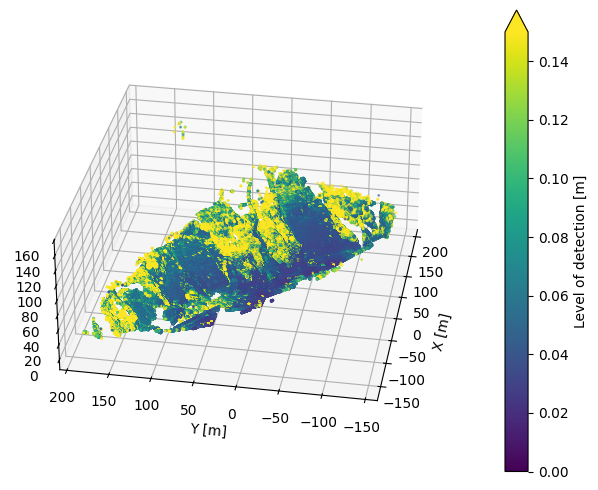

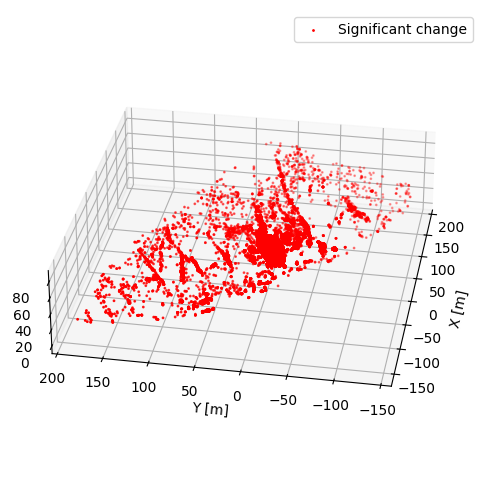

In [28]:
# Plot 1: Distances
fig1 = plt.figure(figsize=(7, 5))
ax1 = fig1.add_subplot(111, projection="3d")
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=m3c2_distances,
    cmap="seismic_r",
    vmin=-15.0,
    vmax=15.0,
    s=1,
    marker='.',
)
plt.colorbar(d, format="%.2f", label="Distance [m]", ax=ax1)
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_aspect("equal")
ax1.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_distance.png", dpi=800, bbox_inches="tight")
plt.show()

# Plot 2: Directions
fig2 = plt.figure(figsize=(7, 5))
ax2 = fig2.add_subplot(111, projection="3d")
directions = m3c2.directions()
dz = ax2.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=directions[:, 2],
    cmap="cool",
    s=1,
)
plt.colorbar(dz, format="%.2f", label="Normal Z [0,1]", ax=ax2)
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")
ax2.set_aspect("equal")
ax2.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_directions.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot 3: Level of Detection
fig3 = plt.figure(figsize=(7, 5))
ax3 = fig3.add_subplot(111, projection="3d")
l = ax3.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=uncertainties["lodetection"],
    cmap="viridis",
    vmin=0.0,
    vmax=0.15,
    s=1,
)
plt.colorbar(l, format="%.2f", label="Level of detection [m]", ax=ax3, extend="max")
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Y [m]")
ax3.set_aspect("equal")
ax3.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_detection.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot 4: Significant Change (Boolean)
fig4 = plt.figure(figsize=(7, 5))
ax4 = fig4.add_subplot(111, projection="3d")
ax4.scatter(
    corepoints[change_sign][:, 0],
    corepoints[change_sign][:, 1],
    corepoints[change_sign][:, 2],
    label="Significant change",
    c="red",
    s=1,
)
ax4.legend()
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Y [m]")
ax4.set_aspect("equal")
ax4.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_significant.png", dpi=300, bbox_inches="tight")
plt.show()

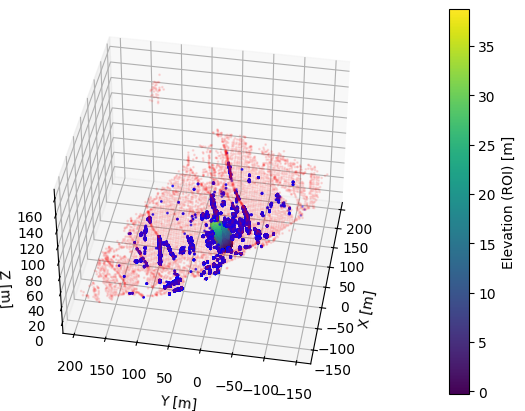

In [29]:
unselected_hulls = [
    hulls[i] for i in range(len(hulls)) if i not in selected_indices
]
inside_nonroi_raw = pipeline.is_inside_selected_hulls_vectorized(
    unselected_hulls, target[:, :2]
)

mask_combined = np.logical_and(~inside_nonroi_raw, ~inside_mask_raw)
unfiltered_raw = target[mask_combined]

filtered_raw_nonroi   = target[inside_nonroi_raw]
filtered_raw_nonroi_x = filtered_raw_nonroi[:, 0]
filtered_raw_nonroi_y = filtered_raw_nonroi[:, 1]
filtered_raw_nonroi_z = filtered_raw_nonroi[:, 2]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

unfiltered_raw_pcd        = o3d.geometry.PointCloud()
unfiltered_raw_pcd.points = o3d.utility.Vector3dVector(unfiltered_raw)
unfiltered_raw_pcd        = unfiltered_raw_pcd.voxel_down_sample(voxel_size=4)
unfiltered_raw_ds         = np.asarray(unfiltered_raw_pcd.points)

unfiltered_raw_x = unfiltered_raw_ds[:, 0]
unfiltered_raw_y = unfiltered_raw_ds[:, 1]
unfiltered_raw_z = unfiltered_raw_ds[:, 2]

scatter_unaffected = ax.scatter(
    filtered_raw_x[::1],
    filtered_raw_y[::1],
    filtered_raw_z[::1],
    c=filtered_raw_z[::1],
    cmap="viridis",
    s=1,
    marker="o",
)
scatter_affected = ax.scatter(
    unfiltered_raw_x[::1],
    unfiltered_raw_y[::1],
    unfiltered_raw_z[::1],
    c="red",
    s=1,
    marker="o",
    alpha=0.1,
)
scatter_unselect = ax.scatter(
    filtered_raw_nonroi_x[::1],
    filtered_raw_nonroi_y[::1],
    filtered_raw_nonroi_z[::1],
    c="blue",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=40.0, azim=190.0)

cbar = plt.colorbar(scatter_unaffected, ax=ax, pad=0.1)
cbar.set_label("Elevation (ROI) [m]")

plt.savefig(f"{log_dir}/ROI.png", dpi=300, bbox_inches="tight")
plt.show()

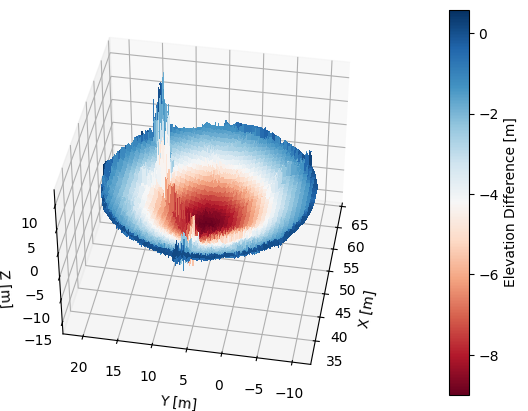

In [30]:
diff_masked = np.ma.masked_invalid(diff_DEMs)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    dem_grid_x, dem_grid_y, diff_masked, cmap="RdBu", linewidth=0, antialiased=False
)

fig.colorbar(surf, ax=ax, pad=0.1, label="Elevation Difference [m]")

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=40.0, azim=190.0)

plt.savefig(f"{log_dir}/PC_DEM_3D.png", dpi=300, bbox_inches="tight")
plt.show()

# Batch Test

In [31]:
# repeat         = 5
# radius_list    = [5, 10, 15, 20]
# max_depth_list = [3,  6,  9, 12]
# noise_std_list = [0.001, 0.01, 0.05, 0.1]

# stable_before, mask_before = pipeline.isolate_stable(target, satble_shp)
# epoch_stabel_before        = py4dgeo.Epoch(stable_before)

# epoch_before          = py4dgeo.Epoch(target)
# corepoints_pcd        = o3d.geometry.PointCloud()
# corepoints_pcd.points = o3d.utility.Vector3dVector(epoch_before.cloud)
# corepoints_pcd        = corepoints_pcd.voxel_down_sample(voxel_size=0.5)
# corepoints            = np.asarray(corepoints_pcd.points)

# results_list = []
# for i in range(len(radius_list)):

#     # Deformation applied
#     sigma = radius_list[i] / 2.0
#     gt_Vol = pipeline.get_analytical_volume(sigma, radius_list[i], max_depth_list[i])
#     z_deformed, mask = pipeline.apply_deformation(
#         x, y, z, center_x, center_y, radius_list[i], max_depth_list[i], sigma
#     )
#     for j in range(len(noise_std_list)):

#         # Noise applied
#         x_noisy, y_noisy, z_noisy = pipeline.apply_noise(x, y, z_deformed, noise_std_list[j])
#         for k in range(repeat):

#             # Random transformation applied
#             T = pipeline.get_random_transformation()
#             gt_T = np.linalg.inv(T)
#             x_trans, y_trans, z_trans = pipeline.apply_transformation(
#                 x_noisy, y_noisy, z_noisy, T
#             )

#             # Altered point cloud saved
#             new_header = laspy.LasHeader(
#                 point_format=las.header.point_format, version=las.header.version
#             )
#             new_header.scales = las.header.scales
#             new_header.offsets = las.header.offsets

#             new_las = laspy.LasData(new_header)
#             new_las.x = x_trans
#             new_las.y = y_trans
#             new_las.z = z_trans

#             new_las.write(f"{log_dir}/radius{i}noise{noise_std_list[j]}_{k}.las")

#             source = np.vstack((x_trans, y_trans, z_trans)).transpose()
#             target = np.vstack((x, y, z)).transpose()

#             # EGS
#             EGS_T = pipeline.EGS(
#                 source=source,
#                 target=target,
#                 voxel_size=VOXEL_SIZE,
#                 padding=PADDING,
#                 ppv=PPV,
#                 pv=PV,
#                 nv=NV,
#                 num_workers=NUM_WORKERS,
#                 rotation_choice=ROTATION_CHOICE,
#                 rotation_root_path="exhaustive-grid-search/data/rotations",
#             )

#             # GICP
#             GICP_T = pipeline.auto_GICP(
#                 source=source,
#                 target=target,
#                 T_init=EGS_T,
#                 thr=QUANTILE_THR,
#                 max_iter=2048,
#             )

#             rre = pipeline.compute_rre(EGS_T, gt_T)
#             rte = pipeline.compute_rte(EGS_T, gt_T)
#             rre_refined = pipeline.compute_rre(GICP_T, gt_T)
#             rte_refined = pipeline.compute_rte(GICP_T, gt_T)
            
#             x_refined, y_refined, z_refined = pipeline.apply_transformation(x_trans, y_trans, z_trans, GICP_T)
#             refined = np.vstack((x_refined, y_refined, z_refined)).transpose()
            
#             # Calculate Point Cloud Registration Uncertainty
#             stable_after,  mask_after  = pipeline.isolate_stable(refined, satble_shp)
#             epoch_stabel_after  = py4dgeo.Epoch(stable_after)
            
#             m3c2 = py4dgeo.M3C2(
#                 epochs=(epoch_stabel_before, epoch_stabel_after),
#                 corepoints=epoch_stabel_before.cloud[::],
#                 normal_radii=(0.5,),
#                 cyl_radius=(0.5),
#                 max_distance=(5.0),
#                 registration_error=(0.0),
#             )
#             m3c2_distances_stableparts, uncertainties_stableparts = m3c2.run()
#             reg_target_source = np.nanstd(m3c2_distances_stableparts)
            
#             # Calculate Point Cloud Changes
#             epoch_after = py4dgeo.Epoch(refined)

#             m3c2 = py4dgeo.M3C2(
#                 epochs=(epoch_before, epoch_after),
#                 corepoints=corepoints,
#                 normal_radii=(0.5,),
#                 cyl_radii=(0.5,),
#                 max_distance=(15.0),
#                 registration_error=(reg_target_source),
#             )
#             m3c2_distances, uncertainties = m3c2.run()
#             change_sign = np.where(abs(m3c2_distances) > uncertainties["lodetection"], True, False)
            
#             # Segment changes
#             n = np.floor(np.log10(len(corepoints[change_sign])))
#             thr = 10 ** (-(n - 2))
            
#             hulls = pipeline.segment_changes(corepoints, change_sign, 1-thr)

#             selected_indices    = [np.argmax([hull.area for hull in hulls])]
#             selected_hulls      = [hulls[i] for i in selected_indices]
#             inside_mask_refined = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, refined[:, :2])
#             inside_mask_raw     = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, target[:, :2])

#             filtered_refined = refined[inside_mask_refined]
#             filtered_raw     = target[inside_mask_raw]

#             filtered_refined_x, filtered_refined_y, filtered_refined_z = filtered_refined.T
#             filtered_raw_x, filtered_raw_y, filtered_raw_z = filtered_raw.T
            
#             # Generate DEMs
#             dem_before, dem_after, dem_grid_x, dem_grid_y = pipeline.reletive_DEM(
#                 filtered_raw,
#                 filtered_refined,
#                 grid_res=0.01,
#                 method="linear",
#                 mask_hulls=selected_hulls,
#             )

#             # Calculate volume difference
#             net_volume, cut_volume, fill_volume, diff_DEMs = pipeline.calculate_volume(
#                 dem_before, dem_after, grid_res=0.01, threshold=reg_target_source
#             )

#             volume_cut_acc = (gt_Vol + net_volume) / gt_Vol * 100
            
#             # Save results
#             result_entry = {
#                 "radius": radius_list[i],
#                 "max_depth": max_depth_list[i],
#                 "noise_std": noise_std_list[j],
#                 "rre": rre,
#                 "rte": rte,
#                 "rre_refined": rre_refined,
#                 "rte_refined": rte_refined,
#                 "cut_volume": cut_volume,
#                 "fill_volume": fill_volume,
#                 "net_volume": net_volume,
#                 "volume_cut_acc": volume_cut_acc,
#             }
#             results_list.append(result_entry)
#             print(result_entry)

# results_df = pd.DataFrame(results_list)
# results_df.to_csv(f"{log_dir}/results.csv", index=False)
# print("Results saved to CSV file.")